# Прогнозирование оттока клиентов в сети отелей «Как в гостях».

Сеть отелей "Как в гостях" столкнулась с проблемой убытков из-за отмены бронирования номеров при отсутствии предоплаты. 

Целью данного проекта является разработка и внедрение системы прогнозирования отказов от бронирования. В случае высокой вероятности отмены брони система должна предлагать клиентам внести депозит в размере 80% от стоимости номера за одни сутки и затрат на разовую уборку. 

На разработку системы прогнозирования заложен бюджет — 400 000 руб., внедрение модели должно окупиться за тестовый период. 

В проекте будет осуществляться решение задачи бинарной классификации с применением методов обучения с учителем.


**Описание данных**
Данные предоставленные на анализ состоят из двух таблиц: обучающей и тестовой выборок. В таблицах содержатся одинаковые столбцы:

`id` — номер записи;

`adults` — количество взрослых постояльцев;

`arrival_date_year` — год заезда;

`arrival_date_month` — месяц заезда;

`arrival_date_week_number` — неделя заезда;

`arrival_date_day_of_month` — день заезда;

`babies` — количество младенцев;

`booking_changes` — количество изменений параметров заказа;

`children` — количество детей от 3 до 14 лет;

`country` — гражданство постояльца;

`customer_type` — тип заказчика:
* `Contract` — договор с юридическим лицом;
* `Group` — групповой заезд;
* `Transient` — не связано с договором или групповым заездом;
* `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа Transient.

`days_in_waiting_list` — сколько дней заказ ожидал подтверждения;

`distribution_channel` — канал дистрибуции заказа;

`is_canceled` — отмена заказа;

`is_repeated_guest` — признак того, что гость бронирует номер второй раз;

`lead_time` — количество дней между датой бронирования и датой прибытия;

`meal` — опции заказа:
* `SC` — нет дополнительных опций;
* `BB` — включён завтрак;
* `HB` — включён завтрак и обед;
* `FB` — включён завтрак, обед и ужин.

`previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;

`previous_cancellations` — количество отменённых заказов у клиента;

`required_car_parking_spaces` — необходимость места для автомобиля;

`reserved_room_type` — тип забронированной комнаты;

`stays_in_weekend_nights` — количество ночей в выходные дни;

`stays_in_week_nights` — количество ночей в будние дни;

`total_nights` — общее количество ночей;

`total_of_special_requests` — количество специальных отметок.


**Краткий план работы:**

* Исследовательский анализ данных.

* Предобработка данных.

* Оценка бизнес-метрики.

* Разработка модели машинного обучения.

* Оценка бизнес-метрики при внедрении модели.

* Выявление признаков "ненадежного" клиента.

* Общий вывод.


Применение модели, построенной в данном проекте, позволит уменьшить убытки от отмененных броней и обеспечить более эффективное управление затратами на обслуживание.

### Исследовательский анализ  данных.

In [1]:
pip install -q sweetviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import sweetviz as sv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import (
    cross_val_score, 
    StratifiedKFold, 
    GridSearchCV
)
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier

In [3]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

Откроем файлы и выведем на экран 5 случайных строк таблиц.

In [4]:
df_train = pd.read_csv('/datasets/hotel_train.csv')
df_train.sample(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
45159,63603,0,97.00,2015,December,53,30,0,4,2.00,0.00,0.00,BB,FRA,TA/TO,0,0,0,D,0,0,Transient,0,0,4
35070,43010,1,305.00,2016,November,45,4,1,2,2.00,0.00,0.00,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,3
52025,70592,0,87.00,2016,May,22,27,0,1,1.00,0.00,0.00,BB,USA,TA/TO,0,0,0,A,0,0,Transient,0,1,1
51578,70131,1,0.00,2016,December,52,20,0,1,1.00,0.00,0.00,BB,PRT,TA/TO,1,0,6,A,0,0,Transient,0,2,1
26365,34305,1,2.00,2016,April,18,24,1,0,2.00,0.00,0.00,SC,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1


In [5]:
df_test = pd.read_csv('/datasets/hotel_test.csv')
df_test.sample(5)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
6849,23804,0,84.00,2017,June,26,28,0,3,1.00,0.00,0.00,BB,PRT,TA/TO,0,0,0,A,0,0,Transient-Party,1,0,3
22103,87595,0,68.00,2017,March,11,14,0,4,2.00,0.00,0.00,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,4
10238,47427,1,30.00,2017,March,12,20,1,2,2.00,0.00,0.00,SC,ITA,TA/TO,0,0,0,A,0,0,Transient,0,0,3
24012,89504,0,79.00,2017,April,15,13,0,3,2.00,0.00,0.00,SC,ITA,TA/TO,0,0,0,A,0,0,Transient,0,0,3
28920,94412,0,167.00,2017,June,26,30,0,2,2.00,2.00,0.00,BB,SWE,TA/TO,0,0,0,F,0,0,Transient,0,0,2


Выясним особенности данный и сравним содержание выборок.

In [6]:
my_report = sv.compare([df_train, 'Train Data'],[df_test, 'Test Data'])

                                             |          | [  0%]   00:00 -> (? left)


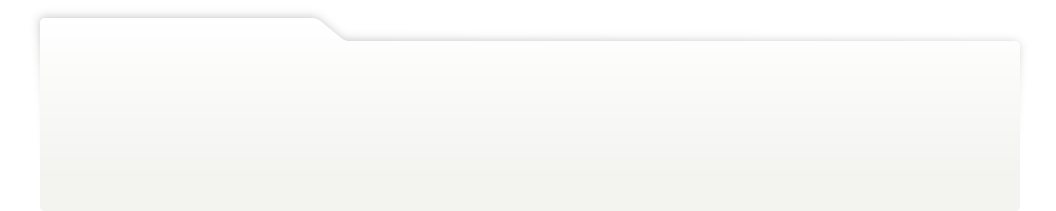
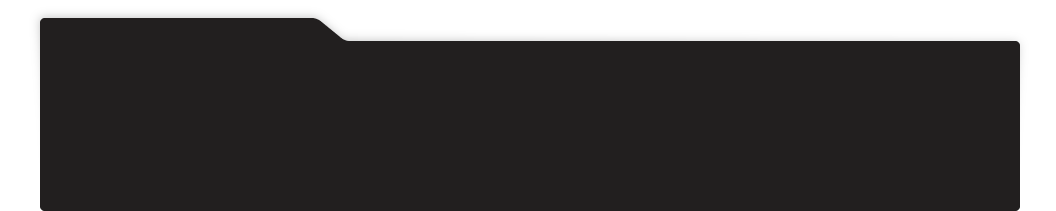
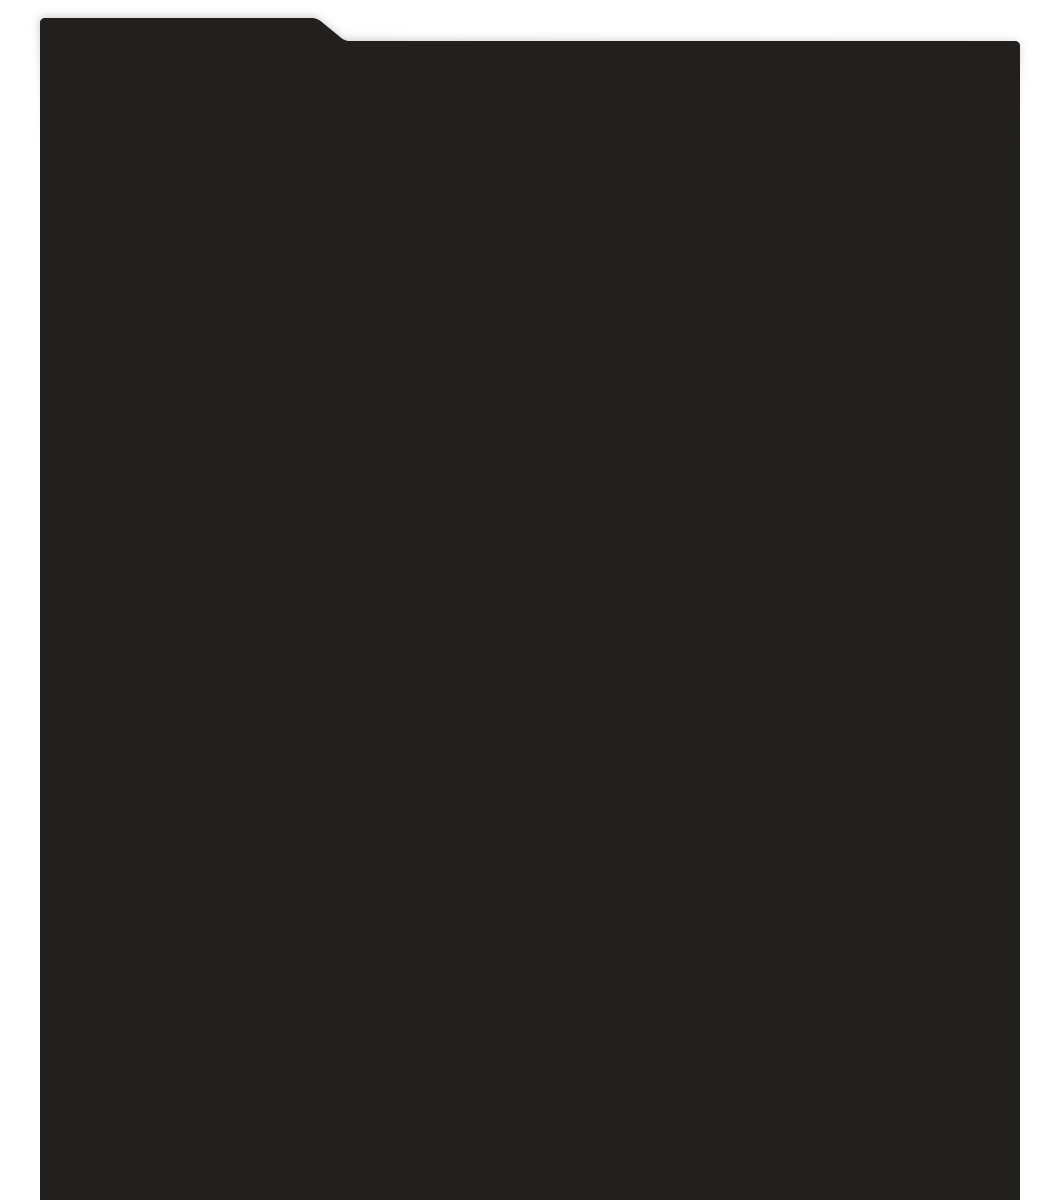
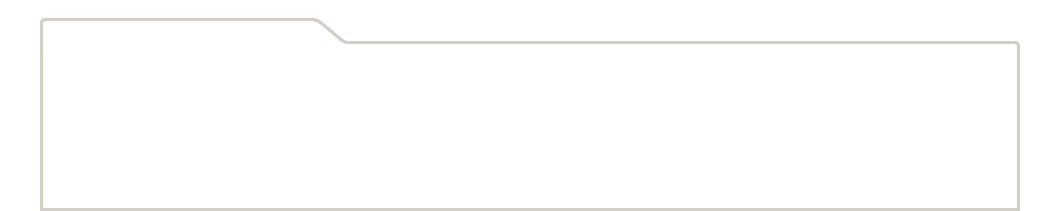
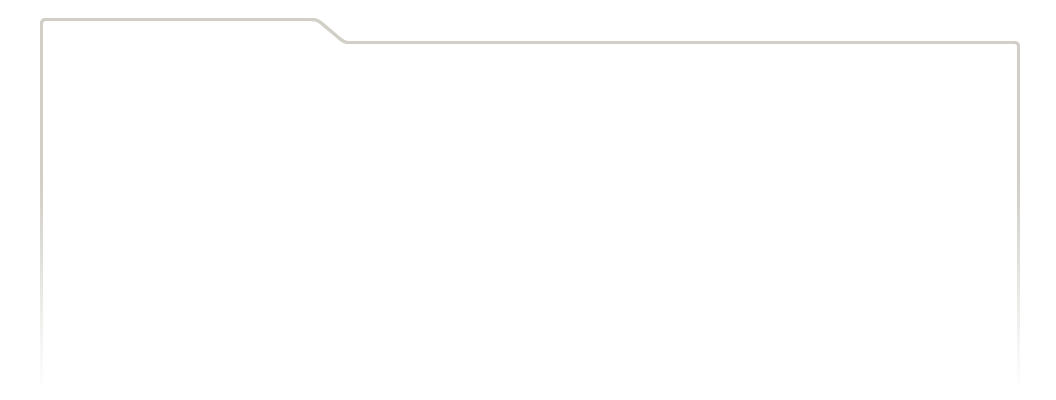
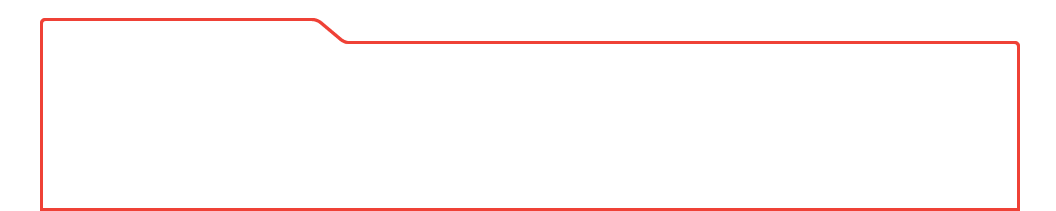
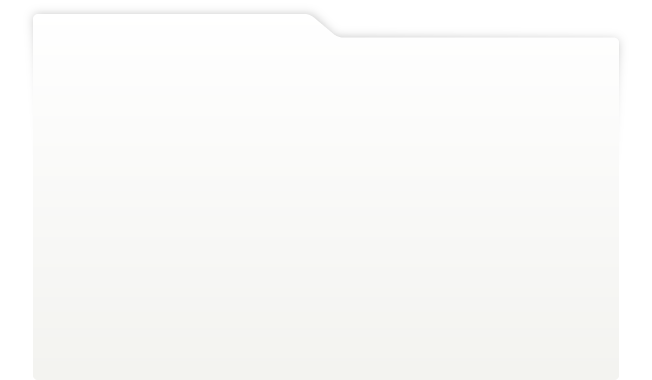
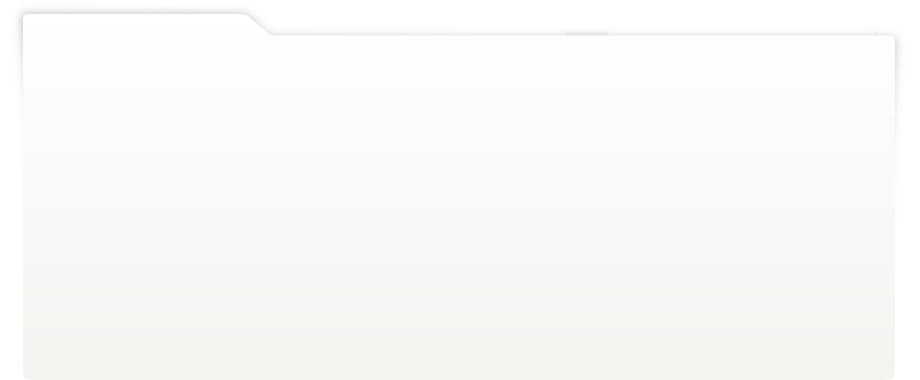
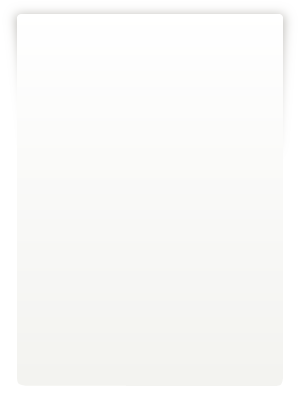
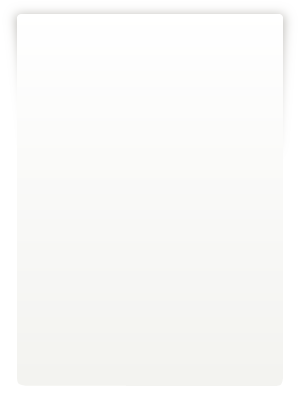
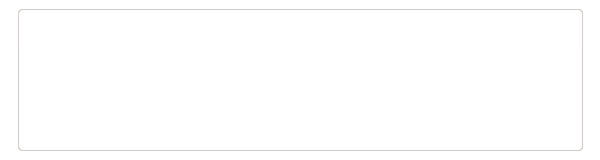
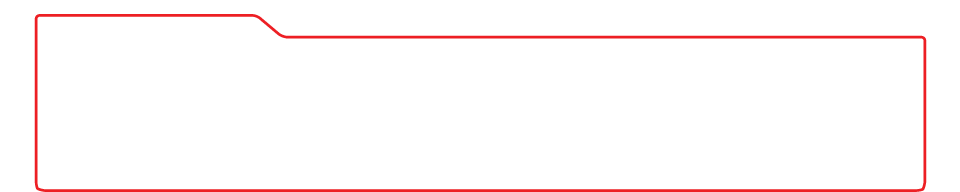
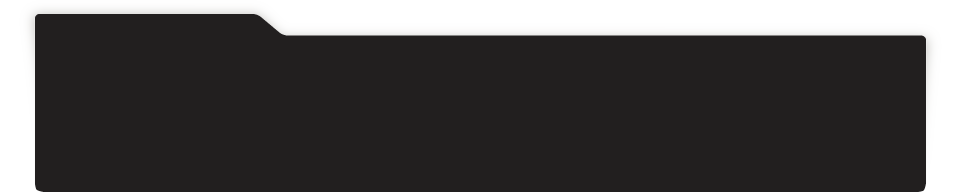
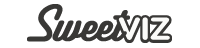
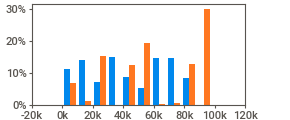
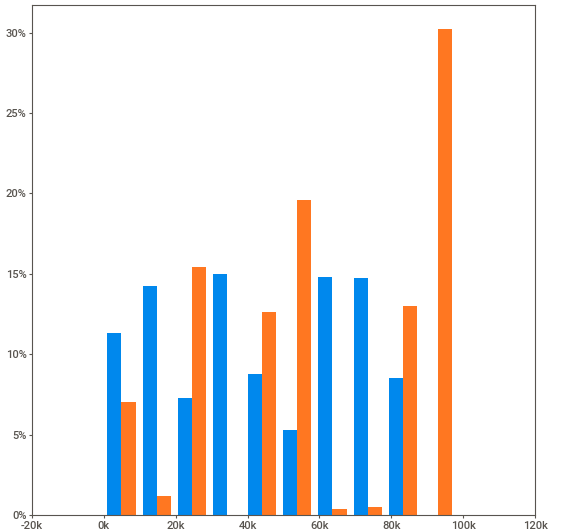
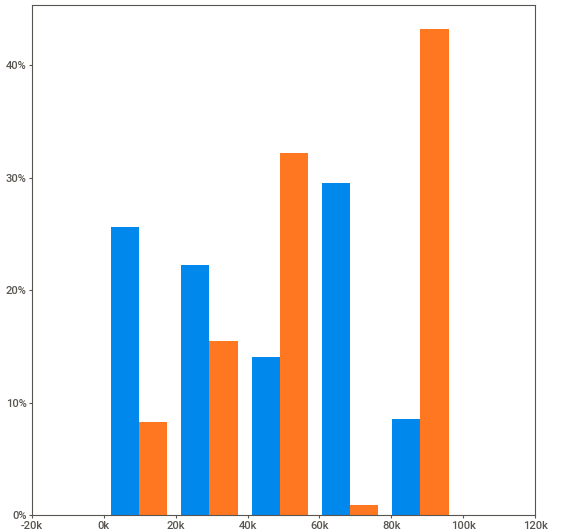
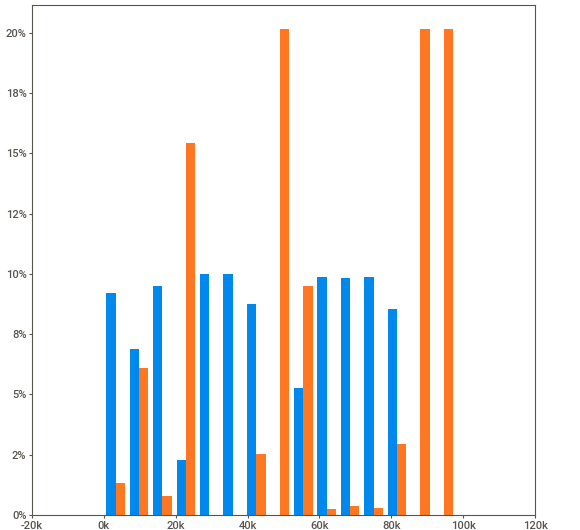
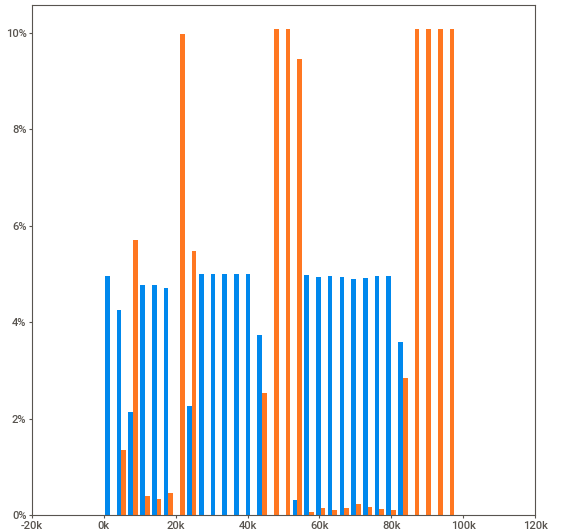
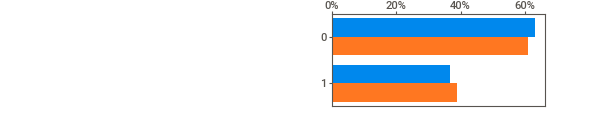
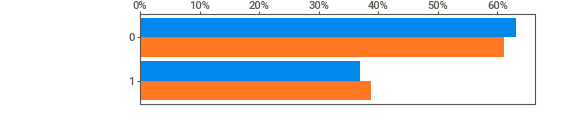
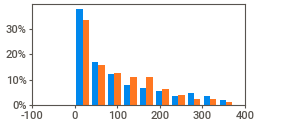
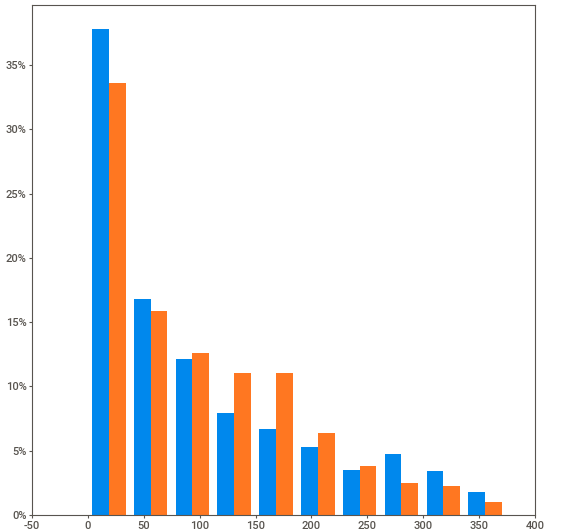
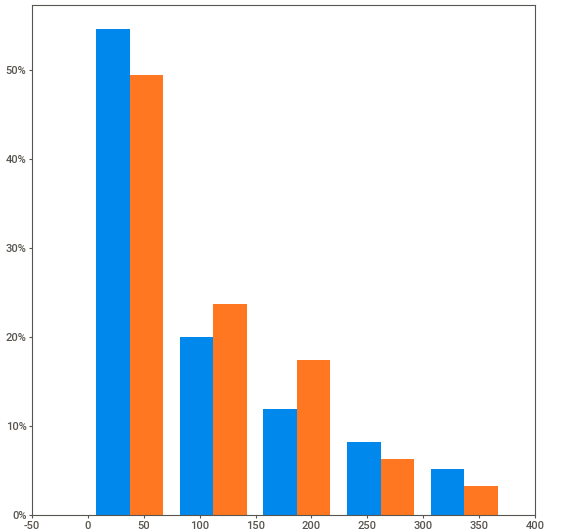
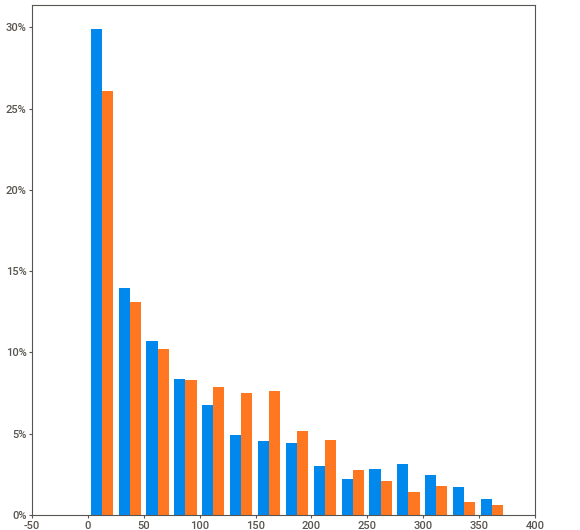
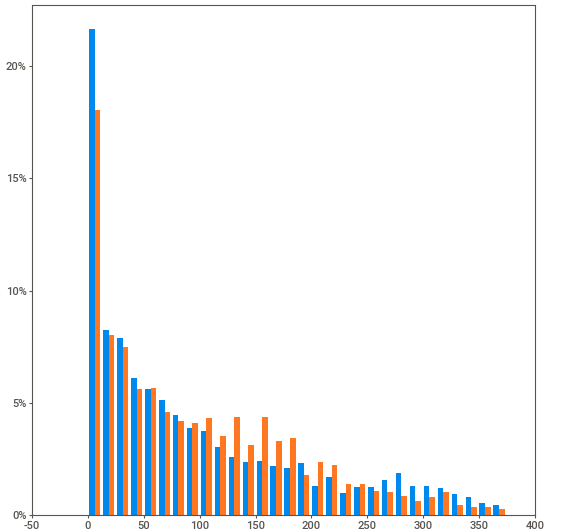
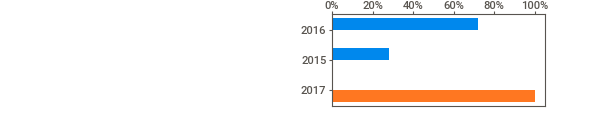
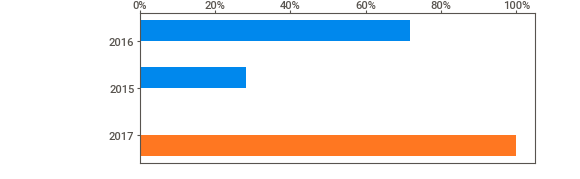
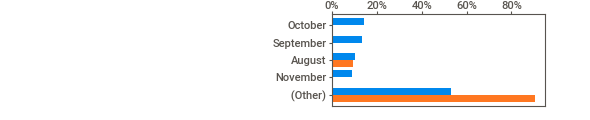
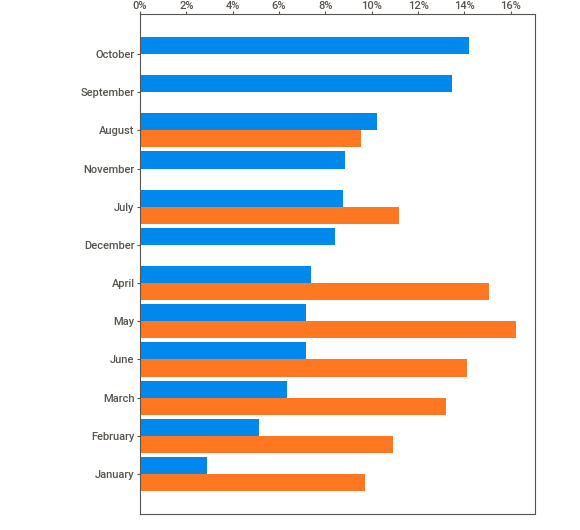
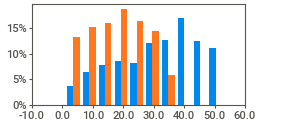
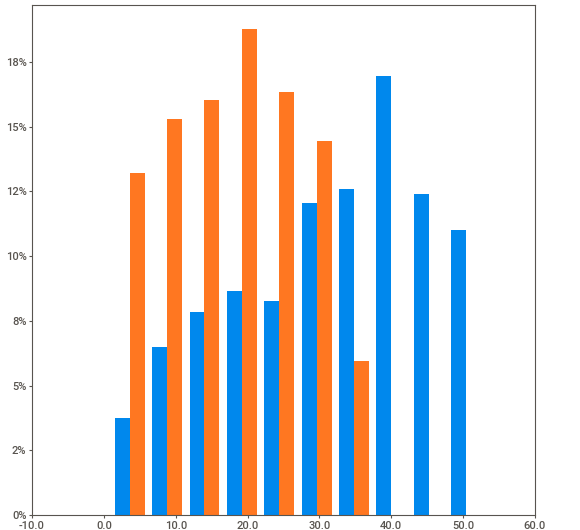
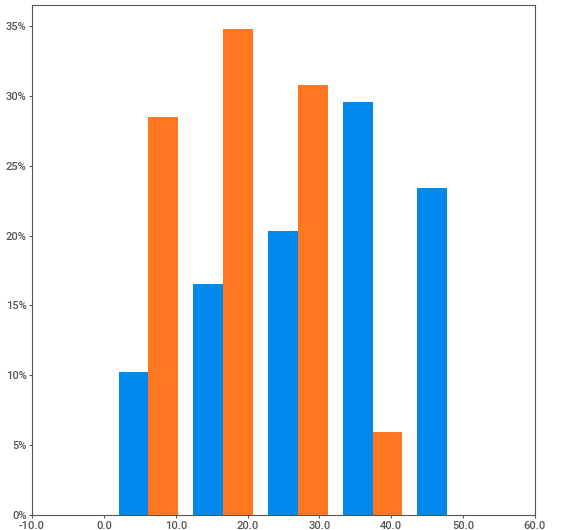
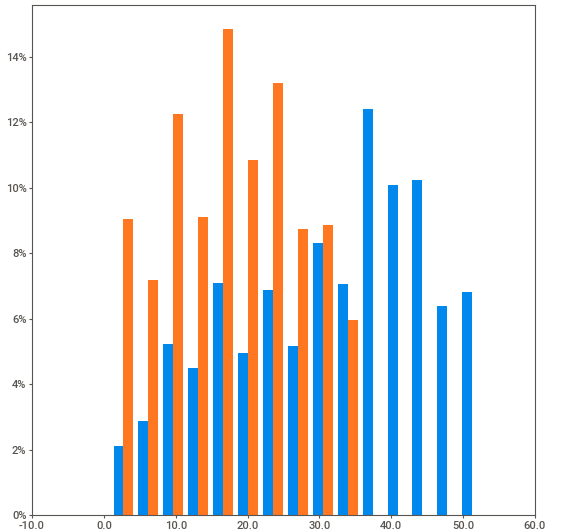
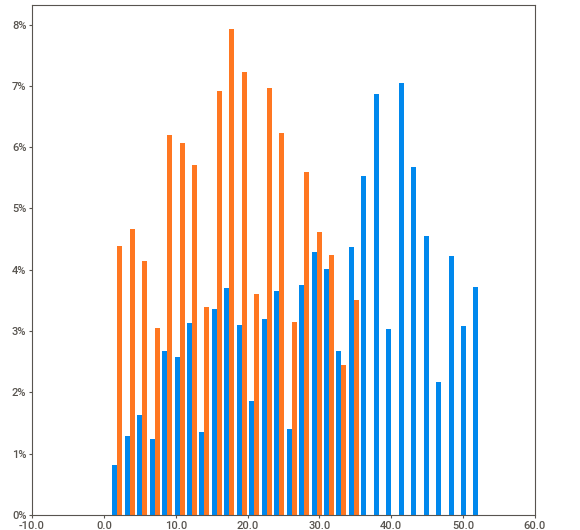
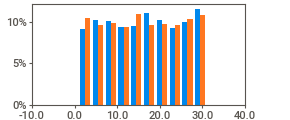
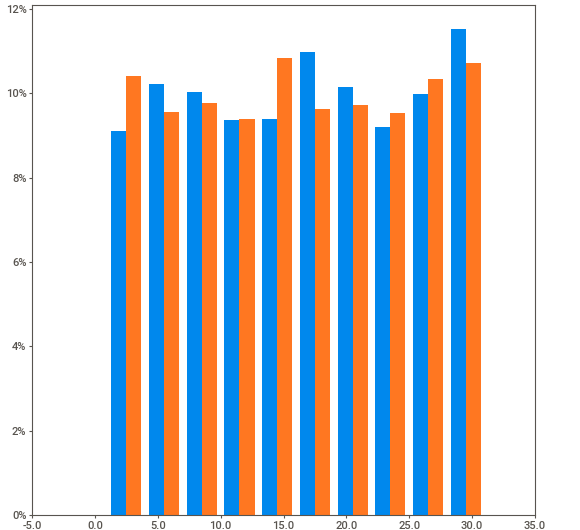
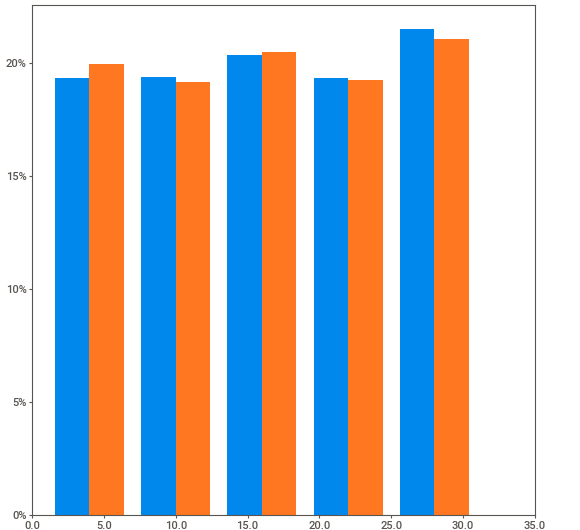
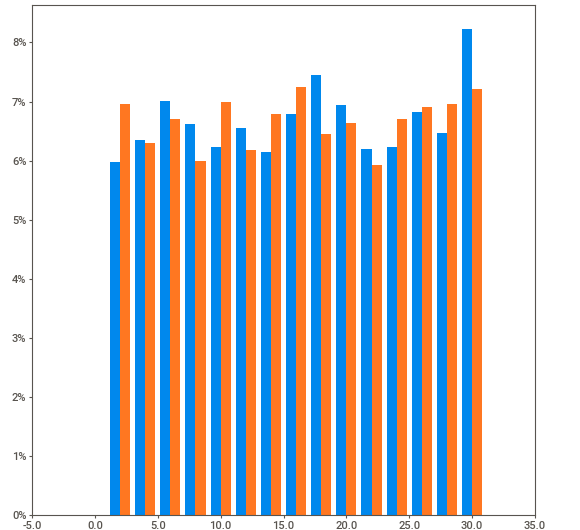
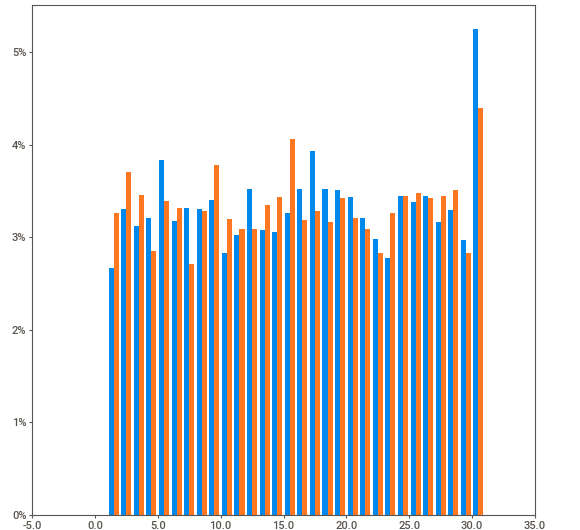
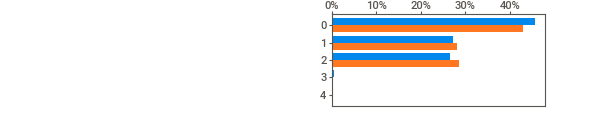
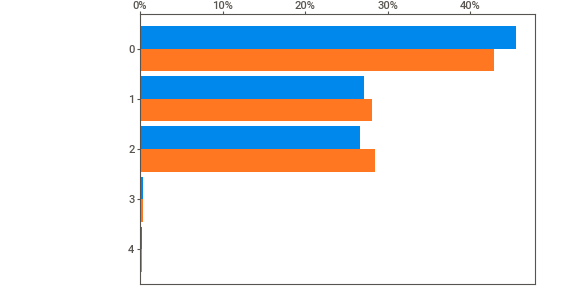
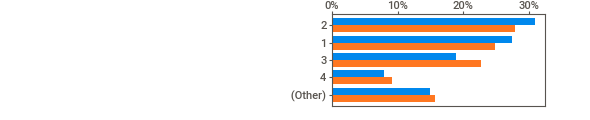
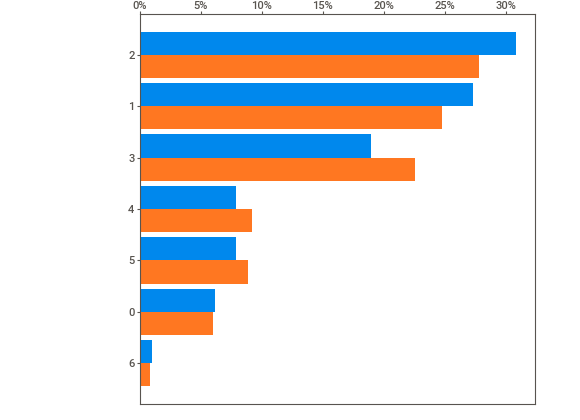
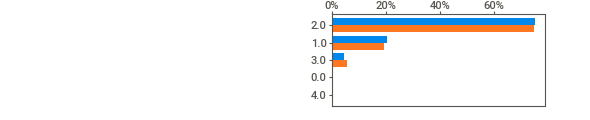
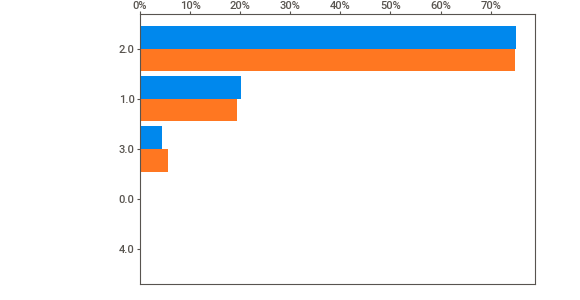
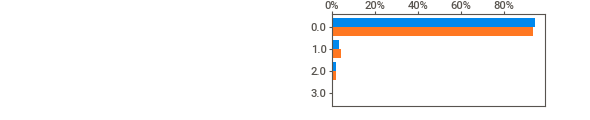
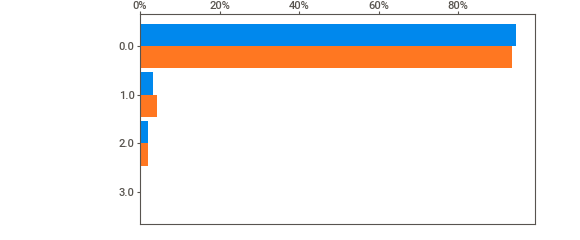
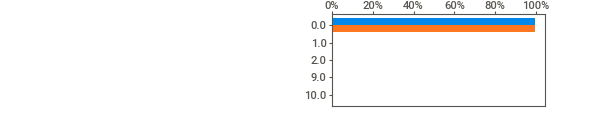
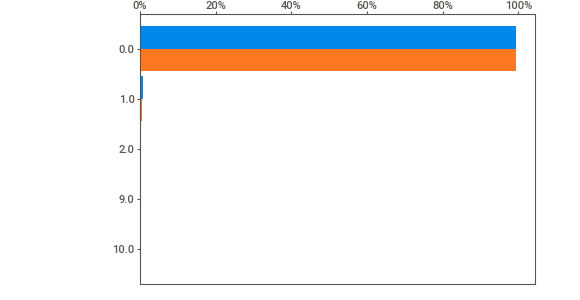
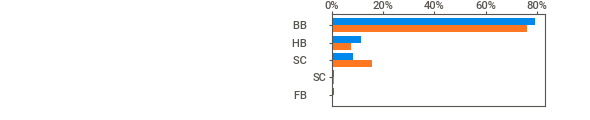
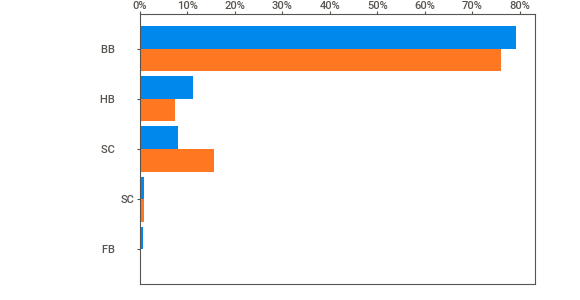
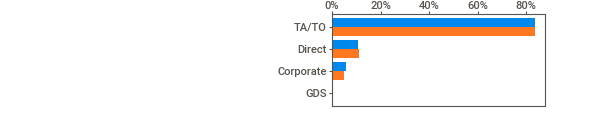
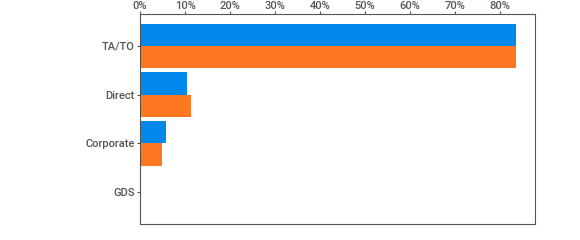
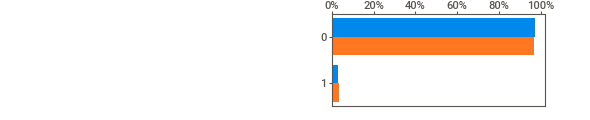
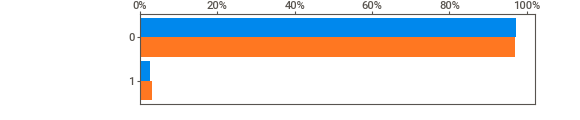
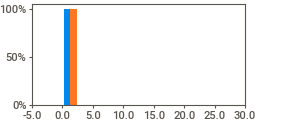
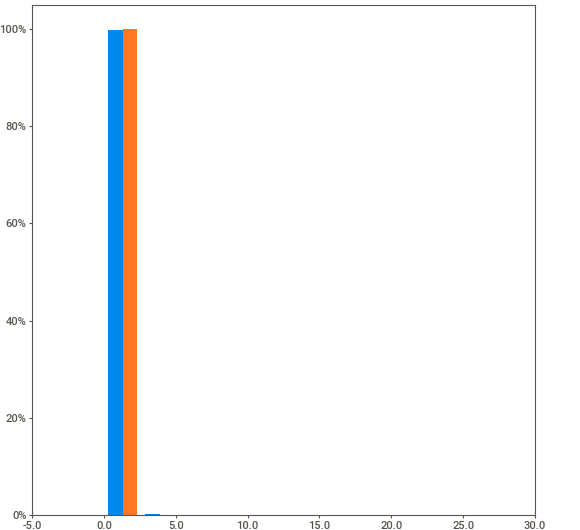
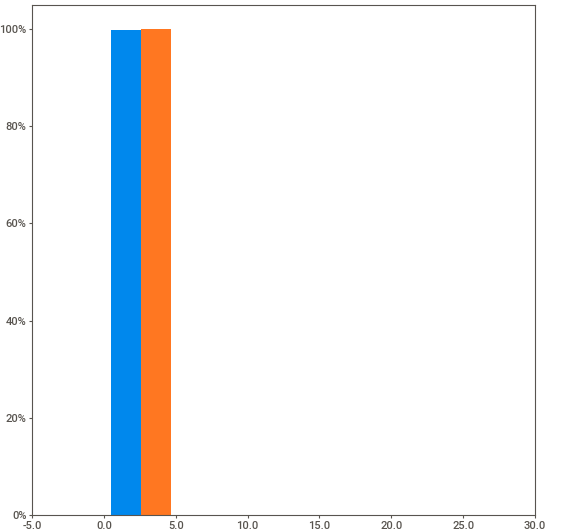
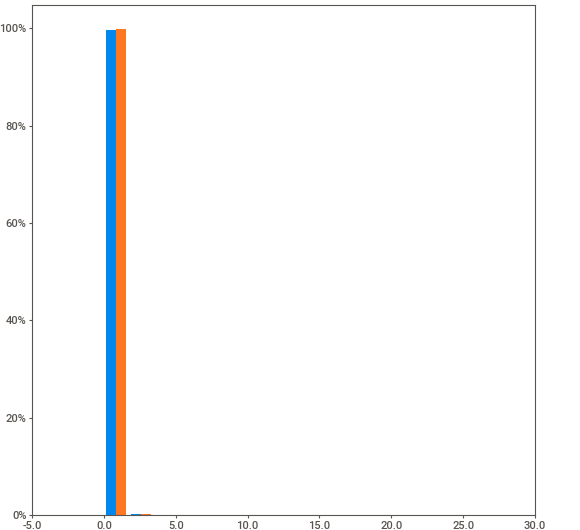
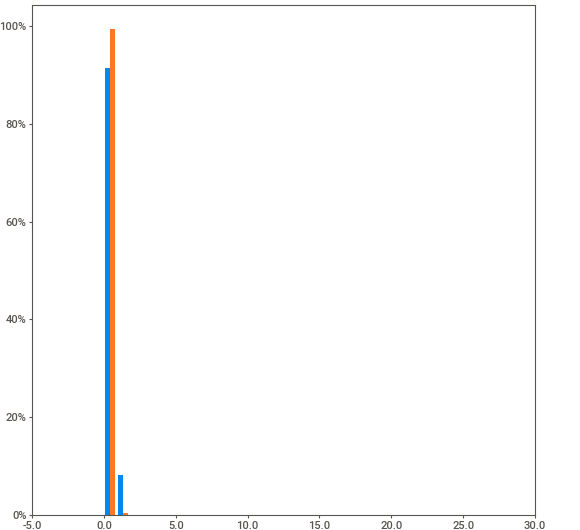
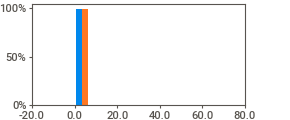
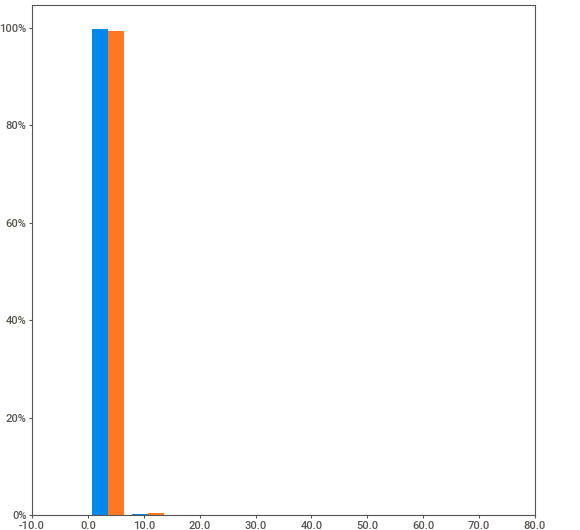
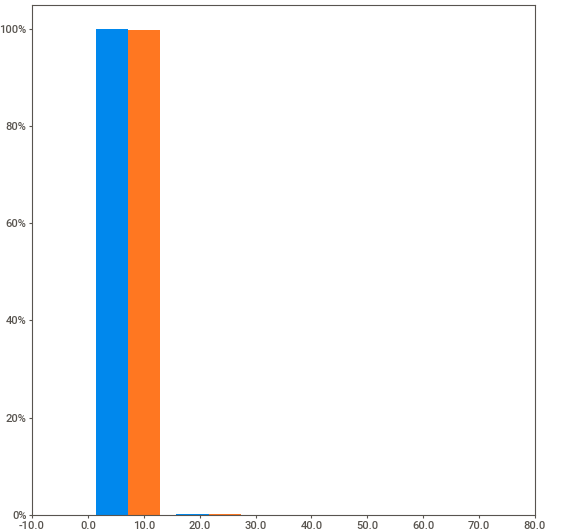
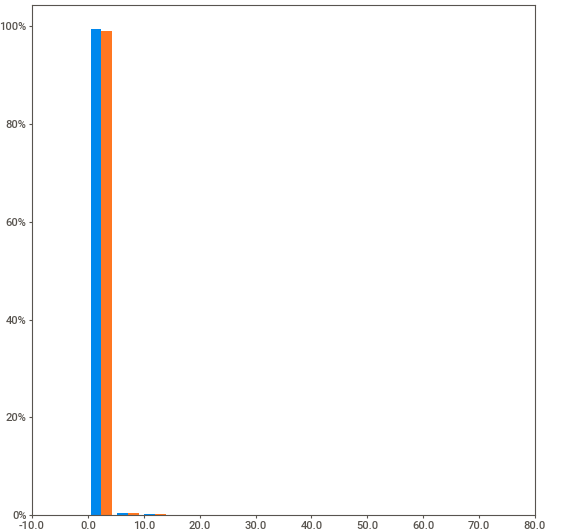
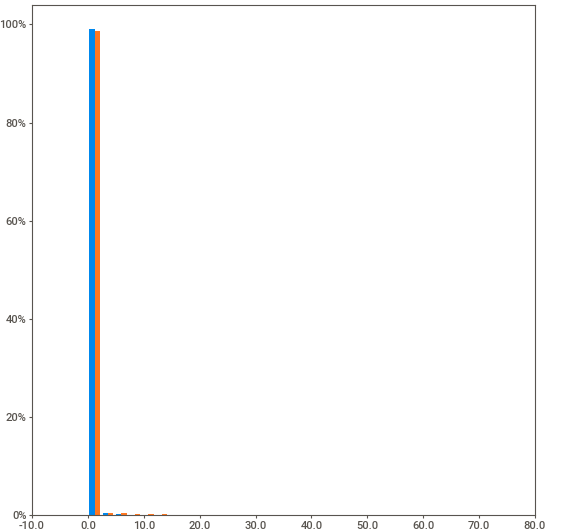
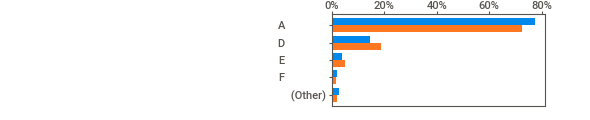
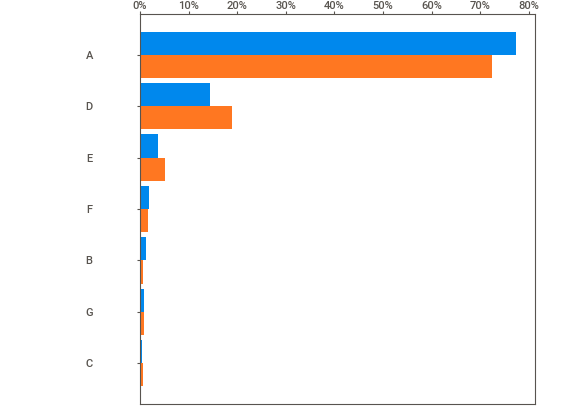
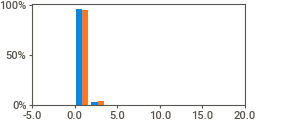
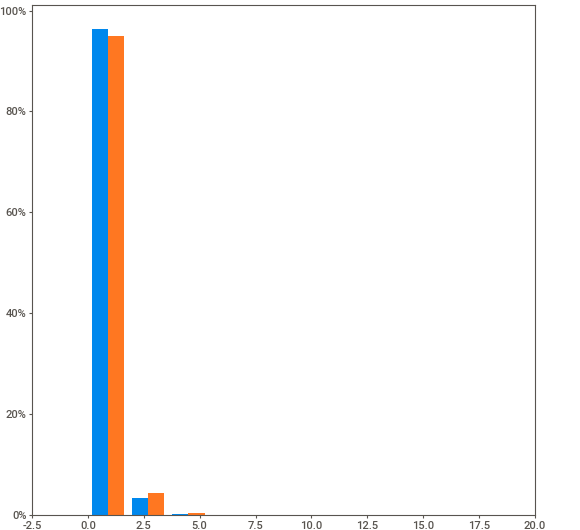
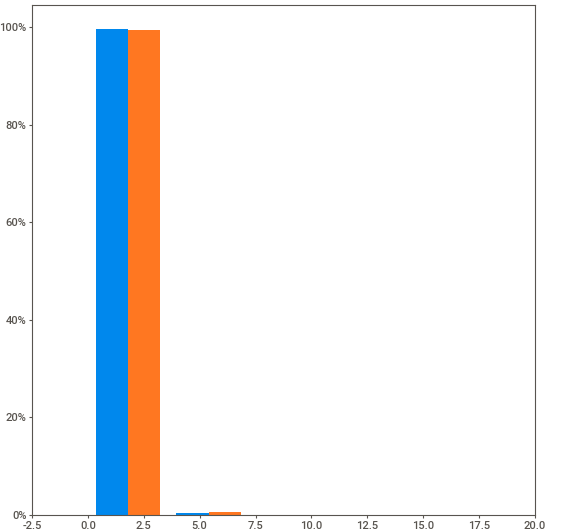
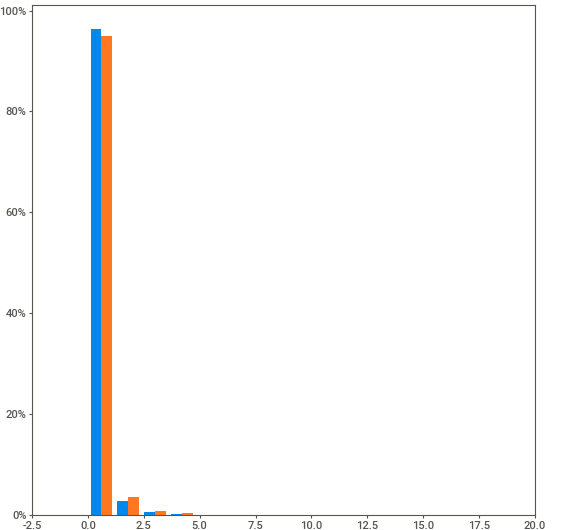
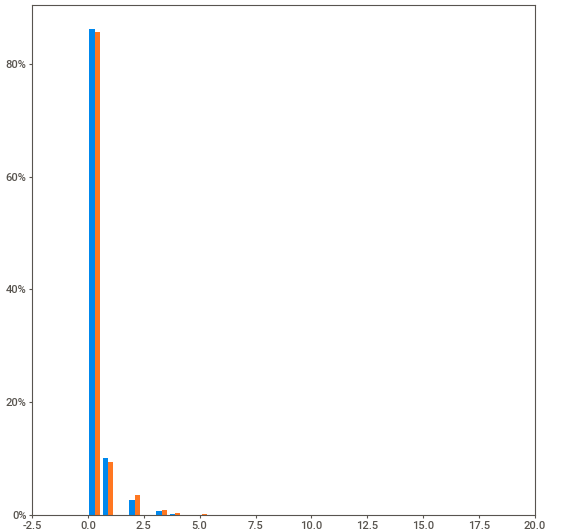
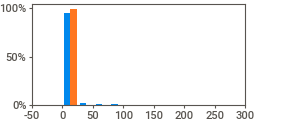
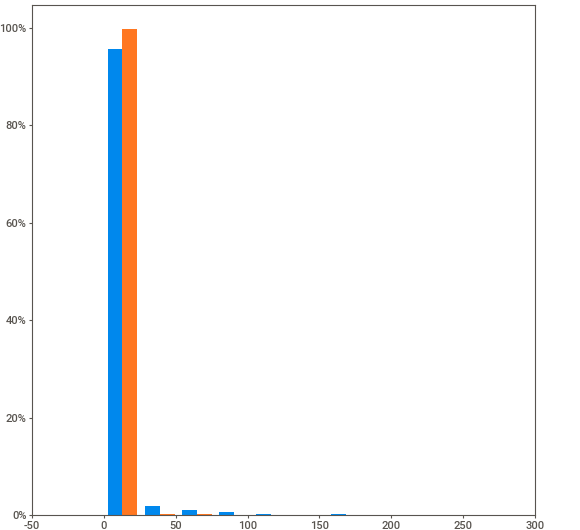
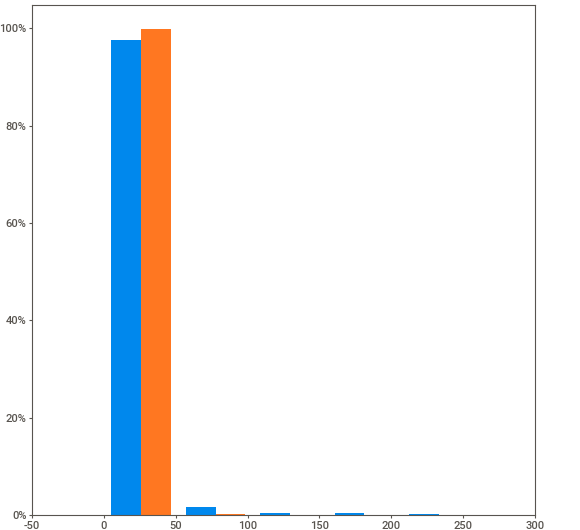
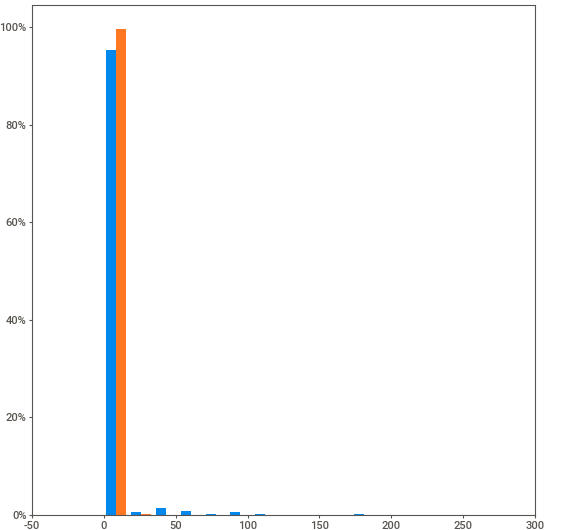
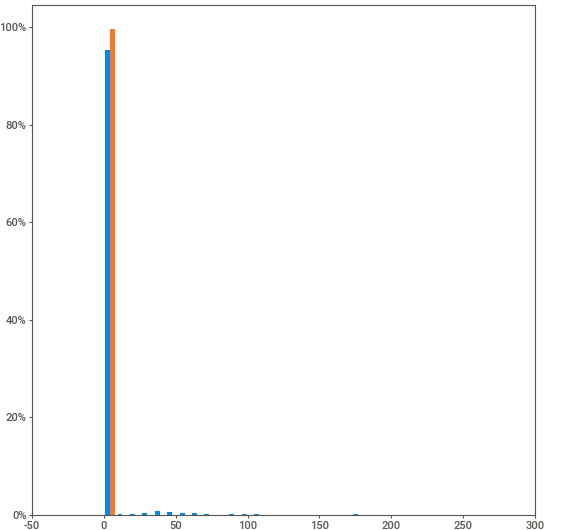
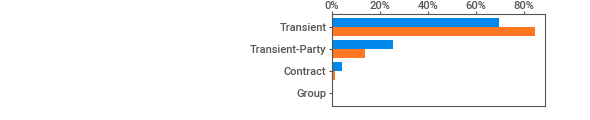
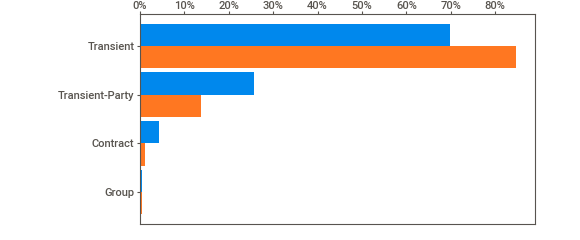
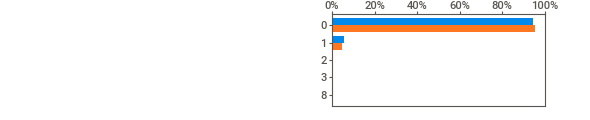
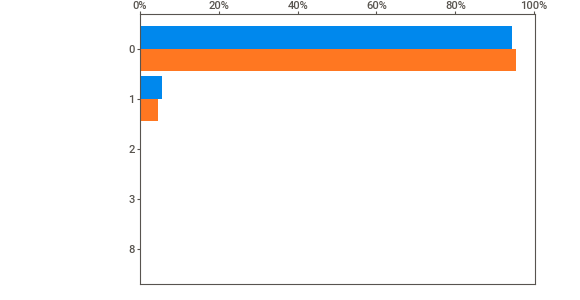
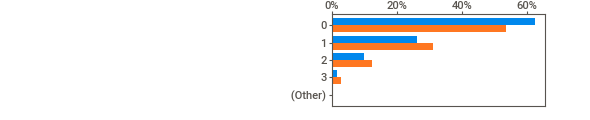
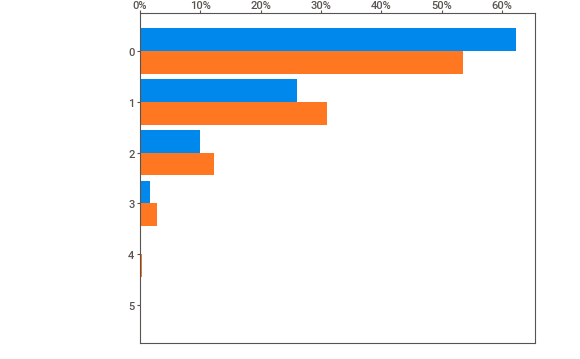
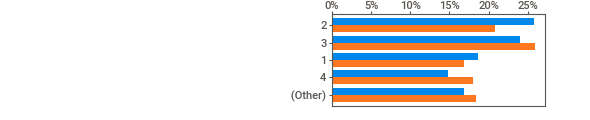
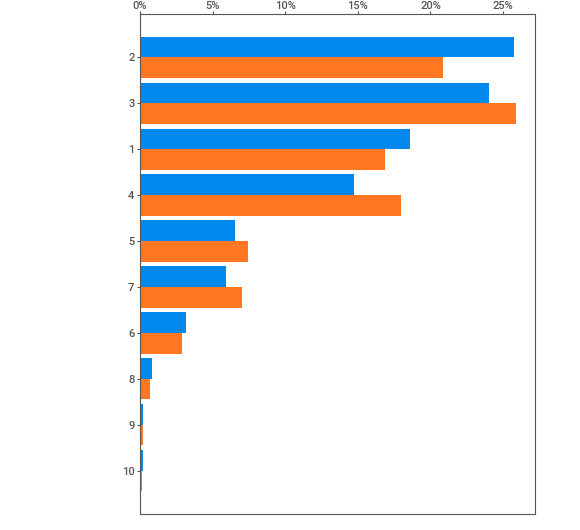
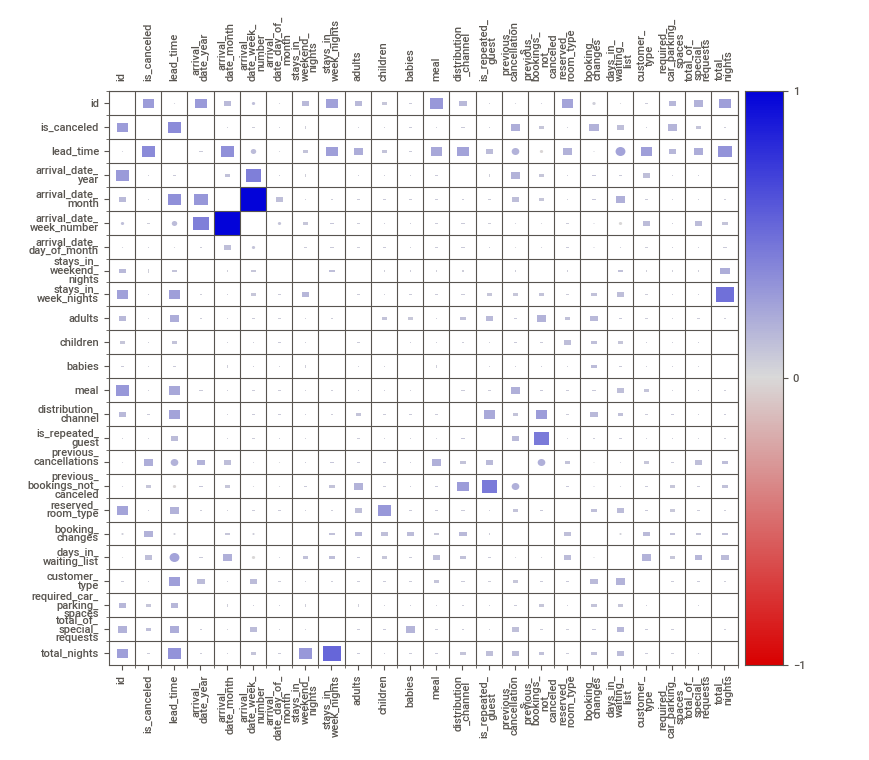
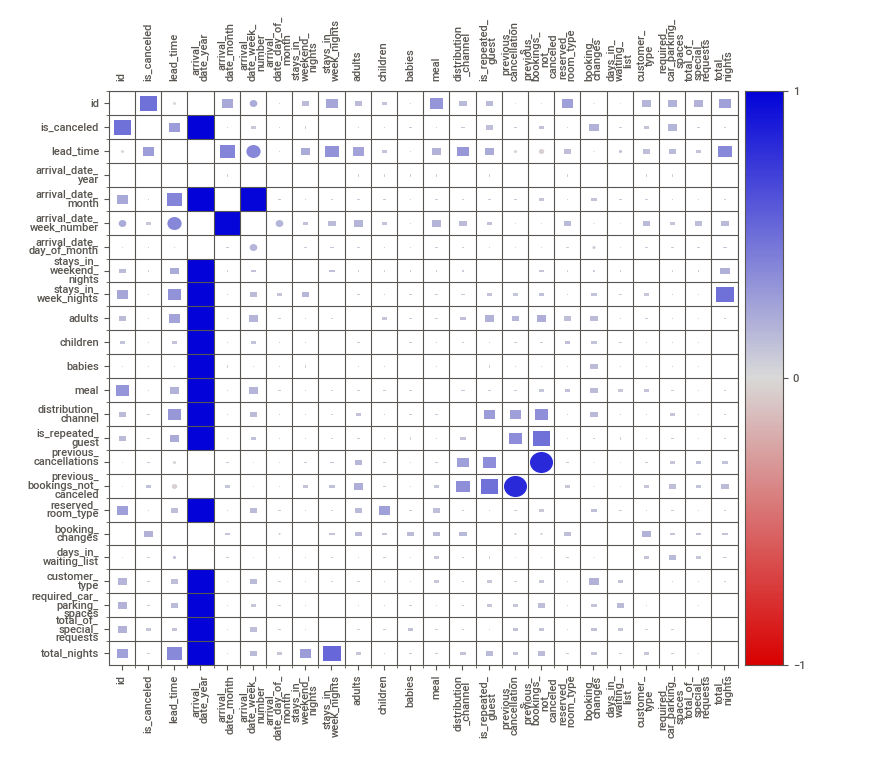

In [7]:
my_report.show_notebook(scale=0.8)

Вычислим к какому периоду относятся данные в обучающей выборке.

In [8]:
df_train.groupby(by='arrival_date_year')['arrival_date_month'].nunique()

arrival_date_year
2015     6
2016    12
Name: arrival_date_month, dtype: int64

**Выводы:**

* Данные, предоставленные для анализа, состоят из двух файлов: обучающей и тестовой выборки.

* Пропусков и явных дубликатов не обнаружено.

* Столбец `id` полностью состоит из уникальных значений в обоих датафреймах и не характеризует клиентов, поэтому его следует удалить.

* Наблюдается дисбаланс целевого признака. Пропорции распределения классов идентичны в обеих выборках.

* Столбцы, имеющие наибольший коэффициент корреляции с целевым признаком: `lead_time`, `id`, `previous_cancellations`, `booking_changes`. 

* В обоих датафреймах в столбце `adults` есть нулевые значения. Следует проверить, был ли номер забронирован на детей или это ошибки.

* Столбец `babies` в обучающей выборке содержит аномально большие значения (9 и 10). Эти строки следует удалить.

* Столбец `meal` должен содержать 4 уникальных значения, а состоит из 5 в обеих выборках.

* Столбец `country` содержит много уникальных значений. Для целей машинного обучения имеет смысл сгруппировать редко встречающиеся значения.

* Столбец `previous_cancellations` в обучающей выборке содержит аномально большие значения. Максимальное значение в этом столбце в тестовой выборке равно 6, его и следует использовать для отсеивания выбросов в обучающей выборке.

* Значения больше 7 в столбце `previous_bookings_not_canceled` следует считать выбросами.

* Значения больше 5 в столбце `booking_changes` следует считать выбросами.

* В столбце ` days_in_waiting_list`в обучающей выборке 95% значений - 0, а в тестовой более 99%. Для обучения моделей этот признак использовать не следует.

* Обучающая выборка состоит из данных за 6 месяцев 2015 года и полный 2016 год, а тестовая – 8 месяцев 2017 года.

* За исследуемый период только 3% клиентов забронировали номер повторно.

* Наиболее популярная категория номера - `А`.

* Большинство гостей относятся к типу заказчика `Transient`. 

* Самая продолжительная бронь - 10 ночей.


### Предобработка данных.

#### Обработка аномалий и выбросов.

Удалим столбцы `id` и `days_in_waiting_list` из обеих таблиц.

In [9]:
data_train = df_train.drop(['id', 'days_in_waiting_list'], axis=1).copy()
data_test = df_test.drop(['id', 'days_in_waiting_list'], axis=1).copy()

Изучим значения в столбце `meal`, чтобы выяснить причину появления пятого уникального значения.

In [10]:
data_train['meal'].unique(), data_test['meal'].unique()

(array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
       dtype=object),
 array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
       dtype=object))

Пятое значение появилось из-за наличия пробелов. Для избежания возможных ошибок, удалим лишние пробелы во всех столбцах типа `object`.

In [11]:
object_columns = data_train.select_dtypes(include='object').columns.to_list()

for col in object_columns:
    data_train[col] = data_train[col].str.strip()
    data_test[col] = data_test[col].str.strip()

Проверим количество уникальных значений в столбце `meal`.

In [12]:
data_train['meal'].unique(), data_test['meal'].unique()

(array(['BB', 'FB', 'HB', 'SC'], dtype=object),
 array(['BB', 'HB', 'SC', 'FB'], dtype=object))

Количество уникальных значений соответствует описанию данных.

Проверим наличие дубликатов.

In [13]:
data_train.duplicated().sum()/data_train.shape[0], data_test.duplicated().sum()/data_test.shape[0]

(0.3277683239050116, 0.23812168332716277)

Треть записей в обучающей выборке и почти четверть в тестовой - дубликаты. Вероятнее всего это следствие ошибок выгрузки данных. Эти строки следует удалить, так как их сохранение может привести к завышенным результат работы моделей из-за эффекта "утечки данных".

In [14]:
data_train = data_train.drop_duplicates()
data_test = data_test.drop_duplicates()

Обработаем аномалии, выявленные на этапе исследования данных.

Найдем и удалим записи неотмененных броней, количество гостей в которых равно 0. 

In [15]:
data_train.loc[
    ((data_train['adults'] + data_train['babies'] + data_train['children']) == 0) & (data_train['is_canceled'] == 0)
]

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
23770,0,48.00,2016,February,9,21,2,4,0.00,0.00,0.00,SC,CHE,Direct,0,0,0,B,2,Transient-Party,0,0,6
26878,0,122.00,2016,May,19,5,2,4,0.00,0.00,0.00,SC,PRT,TA/TO,0,0,0,E,3,Transient,0,0,6
26879,0,122.00,2016,May,19,5,2,4,0.00,0.00,0.00,SC,CHE,TA/TO,0,0,0,E,3,Transient,0,0,6
31570,0,256.00,2016,August,35,21,3,5,0.00,0.00,0.00,BB,PRT,TA/TO,0,0,0,A,1,Transient,0,0,8
41461,0,0.00,2015,November,49,30,1,2,0.00,0.00,0.00,SC,PRT,Corporate,1,0,1,A,2,Transient,0,0,3
50744,0,52.00,2016,April,18,30,2,4,0.00,0.00,0.00,SC,SWE,Direct,0,0,0,E,2,Transient-Party,0,1,6
54881,0,108.00,2016,July,28,5,2,5,0.00,0.00,0.00,SC,PRT,TA/TO,0,0,0,A,0,Transient,0,0,7
56674,0,4.00,2016,August,32,5,2,2,0.00,0.00,0.00,SC,RUS,TA/TO,0,0,0,A,2,Transient,0,2,4
57390,0,88.00,2016,August,34,16,0,4,0.00,0.00,0.00,BB,PRT,TA/TO,0,0,0,D,5,Transient,0,2,4
58416,0,36.00,2016,August,35,27,3,6,0.00,0.00,0.00,SC,ESP,TA/TO,0,0,0,A,2,Transient,0,2,9


In [16]:
data_train = data_train.drop(
    data_train.loc[
        ((data_train['adults'] + data_train['babies'] + data_train['children']) == 0) & (data_train['is_canceled'] == 0)]
    .index)

In [17]:
data_test.loc[
    ((data_test['adults'] + data_test['babies'] + data_test['children']) == 0) & (data_test['is_canceled'] == 0)
]

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
18333,0,55.00,2017,March,10,5,2,0,0.00,0.00,0.00,SC,PRT,Corporate,1,1,9,A,2,Transient,1,0,2
21214,0,50.00,2017,March,9,1,0,3,0.00,0.00,0.00,BB,IRN,TA/TO,0,0,0,A,1,Transient,0,1,3
25596,0,33.00,2017,May,19,9,0,1,0.00,0.00,0.00,SC,PRT,TA/TO,0,0,0,E,3,Transient,0,0,1
28463,0,26.00,2017,June,25,19,1,4,0.00,0.00,0.00,SC,GBR,TA/TO,0,0,0,D,2,Transient,0,1,5
28821,0,107.00,2017,June,26,27,0,3,0.00,0.00,0.00,BB,CHE,TA/TO,0,0,0,A,1,Transient,0,0,3
29808,0,44.00,2017,July,28,15,1,1,0.00,0.00,0.00,SC,SWE,TA/TO,0,0,0,A,2,Transient,0,0,2
30052,0,2.00,2017,July,28,15,2,5,0.00,0.00,0.00,SC,RUS,TA/TO,0,0,0,A,1,Transient-Party,0,1,7


In [18]:
data_test = data_test.drop(
    data_test.loc[
        ((data_test['adults'] + data_test['babies'] + data_test['children']) == 0) & (data_test['is_canceled'] == 0)]
    .index)

Законодательство РФ и большинства европейских стран не запрещает бронировать номер на имя несовершеннолетних, но существующие ограничения популярных европейских систем бронирования не позволяют забронировать номер, если количество младенцев превышает количество взрослых в номере. 

Найдем и удалим записи неотмененных броней, в которых количество младенцев превышает количество зарегистрированных взрослых.

In [19]:
data_train.loc[(data_train['adults'] < data_train['babies']) & (data_train['is_canceled'] == 0)]

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
22534,0,6.00,2015,December,51,18,0,1,0.00,2.00,1.00,BB,PRT,TA/TO,0,0,0,B,0,Transient-Party,0,2,1
22995,0,37.00,2016,January,3,12,0,2,2.00,0.00,10.00,BB,PRT,TA/TO,0,0,0,D,1,Transient,0,1,2
41528,0,11.00,2015,October,42,11,2,1,1.00,0.00,9.00,BB,GBR,Corporate,0,0,0,A,1,Transient-Party,0,0,3
52923,0,14.00,2016,June,24,9,0,3,0.00,2.00,1.00,BB,ITA,TA/TO,0,0,0,B,2,Transient,0,2,3


In [20]:
data_train = data_train.drop(
    data_train.loc[(data_train['adults'] < data_train['babies']) & (data_train['is_canceled'] == 0)].index)

In [21]:
data_test.loc[(data_test['adults'] < data_test['babies']) & (data_test['is_canceled'] == 0)]

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


Переименуем значения в столбце `country` частота встречаемости которых меньше 1%.

In [22]:
country_part = data_train['country'].value_counts(normalize=True) # вычисляем долю каждой страны
top_countries = country_part[country_part >= 0.01].index # список часто встречающихся стран в обучающей выборке
data_train['country'] = data_train['country'].apply(lambda x: x if x in top_countries else 'Other') 
data_test['country'] = data_test['country'].apply(lambda x: x if x in top_countries else 'Other')

if data_train['country'].nunique() == data_test['country'].nunique():
    print(f'Количество уникальных значений столбца в обеих выборках: {data_train.country.nunique()}')
    
else: print("Ошибка")

Количество уникальных значений столбца в обеих выборках: 14


Преобразуем столбцы типа `object` в `category`.

In [23]:
for col in object_columns:
    data_train[col] = data_train[col].astype('category')
    data_test[col] = data_test[col].astype('category')

Удалим выбросы в датафреймах.

In [24]:
columns_to_check = ['previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes']
limits = [6, 7, 5]

for column, limits in zip(columns_to_check, limits):
    data_train = data_train.drop(data_train.query(f'{column} > {limits}').index)
    data_test = data_test.drop(data_test.query(f'{column} > {limits}').index)

Выведем на экран основные статистические характеристики данных.

In [25]:
data_train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
is_canceled,"43,533.00",NaN,NaN,NaN,0.26,0.44,0.00,0.00,0.00,1.00,1.00
lead_time,"43,533.00",NaN,NaN,NaN,68.02,73.96,0.00,9.00,41.00,103.00,374.00
arrival_date_year,"43,533.00",NaN,NaN,NaN,"2,015.77",0.42,"2,015.00","2,016.00","2,016.00","2,016.00","2,016.00"
arrival_date_month,43533,12,October,5488,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,"43,533.00",NaN,NaN,NaN,31.12,13.88,1.00,20.00,33.00,43.00,53.00
arrival_date_day_of_month,"43,533.00",NaN,NaN,NaN,15.92,8.86,1.00,8.00,16.00,24.00,31.00
stays_in_weekend_nights,"43,533.00",NaN,NaN,NaN,0.90,0.87,0.00,0.00,1.00,2.00,4.00
stays_in_week_nights,"43,533.00",NaN,NaN,NaN,2.32,1.46,0.00,1.00,2.00,3.00,6.00
adults,"43,533.00",NaN,NaN,NaN,1.86,0.50,0.00,2.00,2.00,2.00,4.00
children,"43,533.00",NaN,NaN,NaN,0.11,0.40,0.00,0.00,0.00,0.00,3.00


In [26]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
is_canceled,"24,461.00",NaN,NaN,NaN,0.32,0.47,0.00,0.00,0.00,1.00,1.00
lead_time,"24,461.00",NaN,NaN,NaN,89.36,85.47,0.00,17.00,64.00,144.00,373.00
arrival_date_year,"24,461.00",NaN,NaN,NaN,"2,017.00",0.00,"2,017.00","2,017.00","2,017.00","2,017.00","2,017.00"
arrival_date_month,24461,8,May,3699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,"24,461.00",NaN,NaN,NaN,18.21,9.43,1.00,10.00,18.00,26.00,35.00
arrival_date_day_of_month,"24,461.00",NaN,NaN,NaN,15.57,8.78,1.00,8.00,15.00,23.00,31.00
stays_in_weekend_nights,"24,461.00",NaN,NaN,NaN,0.92,0.86,0.00,0.00,1.00,2.00,4.00
stays_in_week_nights,"24,461.00",NaN,NaN,NaN,2.39,1.43,0.00,1.00,2.00,3.00,6.00
adults,"24,461.00",NaN,NaN,NaN,1.89,0.49,0.00,2.00,2.00,2.00,4.00
children,"24,461.00",NaN,NaN,NaN,0.11,0.39,0.00,0.00,0.00,0.00,3.00


Все выбросы обработаны.

Визуализируем матрицу корреляции признаков в обучающей выборке в виде тепловой карты.

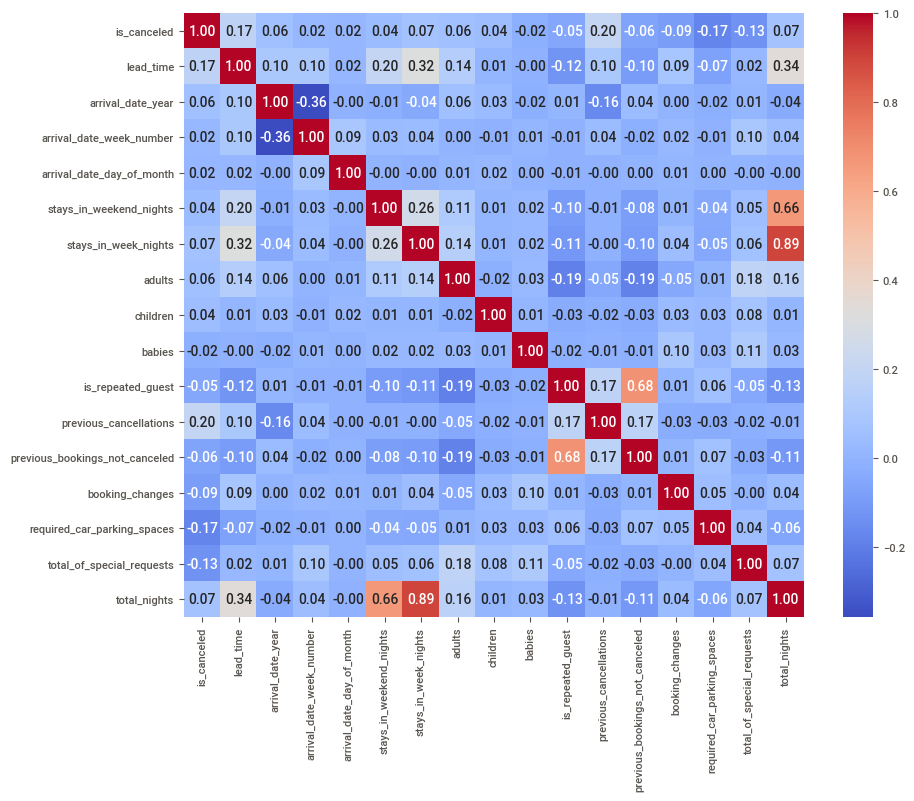

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(data_train.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

Высокая корреляция между признаками, отражающими количество ночей в будни, в выходные и общим количеством ночей ожидаема, так как третий признак представляет собой сумму первого и второго. Для целей машинного обучения следует исключить столбец с общим количеством ночей.

#### Подготовка данных для машинного обучения.

Объявим переменные с именами признаков, классифицированными по категориям.

In [28]:
# целевой признак:
target = 'is_canceled' 

# признаки, которые будут использованы для обучения моделей:
features_all = data_train.columns.difference(['is_canceled', 'arrival_date_year', 'arrival_date_month', 'total_nights'])

# категориальные признаки:
categorical_columns = data_train.select_dtypes(include='category').columns.difference(['arrival_date_month'])

# числовые признаки:
numeric_columns = features_all.difference(categorical_columns)

# числовые бинарные признаки:
binary_columns = [col for col in numeric_columns if data_train[col].nunique() == 2]

# числовые небинарные признаки:
nonbinary_columns = numeric_columns.difference(binary_columns)

In [29]:
features_all

Index(['adults', 'arrival_date_day_of_month', 'arrival_date_week_number',
       'babies', 'booking_changes', 'children', 'country', 'customer_type',
       'distribution_channel', 'is_repeated_guest', 'lead_time', 'meal',
       'previous_bookings_not_canceled', 'previous_cancellations',
       'required_car_parking_spaces', 'reserved_room_type',
       'stays_in_week_nights', 'stays_in_weekend_nights',
       'total_of_special_requests'],
      dtype='object')

Масштабируем числовые небинарные данные.

In [30]:
scaler = StandardScaler()

# Стандартизация обучающего набора данных
nonbinary_columns_train_transformed = (
    pd.DataFrame(scaler.fit_transform(data_train[nonbinary_columns]), columns=nonbinary_columns, index=data_train.index)
    .copy()
)

# Стандартизация тестового набора данных
nonbinary_columns_test_transformed = (
    pd.DataFrame(scaler.transform(data_test[nonbinary_columns]), columns=nonbinary_columns, index=data_test.index)
    .copy()
) 


Преобразуем категориальные признаки в бинарные числовые.

In [31]:
encored = OneHotEncoder(drop='first', sparse=False)

# Кодирование обучающего набора данных
categorical_columns_train_transformed = pd.DataFrame(
    encored.fit_transform(data_train[categorical_columns]),
    columns = encored.get_feature_names(input_features=categorical_columns),
    index=data_train.index
)

# Кодирование тестового набора данных
categorical_columns_test_transformed = pd.DataFrame(
    encored.transform(data_test[categorical_columns]),
    columns = encored.get_feature_names(input_features=categorical_columns),
    index=data_test.index
)

In [32]:
print(f'Общее количество признаков для обучения: {len(features_all)},')
print(f'категориальные признаки: {len(categorical_columns)},')
print(f'числовые признаки: {len(numeric_columns)},')
print(f'числовые бинарные признаки: {len(binary_columns)},')
print(f'числовые небинарные признаки: {len(nonbinary_columns)},')
print(f'закодированные категориальные признаки: {categorical_columns_train_transformed.shape[1]}.')

Общее количество признаков для обучения: 19,
категориальные признаки: 5,
числовые признаки: 14,
числовые бинарные признаки: 1,
числовые небинарные признаки: 13,
закодированные категориальные признаки: 28.


**Выводы**:

* В данных, представленных на анализ, были обнаружены и удалены неявные дубликаты и аномалии.

* Редко встречающиеся названия стран в столбце `country` были переименнованы в `Other`.

* Сильной линейной зависимости между целевым признаком и какой-либо характеристикой клиента не обнаружено.

* Осуществленна классификация признаков для обучения.

* Числовые небинарные данные стандартизированы.

* Категориальные признаки закодированы техникой OHE.

### Оценка бизнес-метрики.

Основная бизнес-метрика сети отелей — прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затратами на обслуживание. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:

* категория A: за ночь — 1 000, разовое обслуживание — 400;

* категория B: за ночь — 800, разовое обслуживание — 350;

* категория C: за ночь — 600, разовое обслуживание — 350;

* категория D: за ночь — 550, разовое обслуживание — 150;

* категория E: за ночь — 500, разовое обслуживание — 150;

* категория F: за ночь — 450, разовое обслуживание — 150;

* категория G: за ночь — 350, разовое обслуживание — 150.

In [33]:
price_list = {
    'A': [1000, 400],
    'B': [800,  350],
    'C': [600,  350],
    'D': [550,  150],
    'E': [500,  150],
    'F': [450,  150],
    'G': [350,  150]
}

price_list

{'A': [1000, 400],
 'B': [800, 350],
 'C': [600, 350],
 'D': [550, 150],
 'E': [500, 150],
 'F': [450, 150],
 'G': [350, 150]}

Сезонные коэффициенты: 

* весной и осенью — 20%; 

* летом — 40%.

In [34]:
season_coef = {
    'January': 1., 'February': 1.,
    'March': 1.2, 'April': 1.2, 'May': 1.2 , 
    'June': 1.4, 'July': 1.4, 'August': 1.4, 
    'September': 1.2, 'October': 1.2, 'November': 1.2,
    'December': 1.
}

season_coef

{'January': 1.0,
 'February': 1.0,
 'March': 1.2,
 'April': 1.2,
 'May': 1.2,
 'June': 1.4,
 'July': 1.4,
 'August': 1.4,
 'September': 1.2,
 'October': 1.2,
 'November': 1.2,
 'December': 1.0}

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

Объявим функцию рассчета прибыли.

In [35]:
def calculate_profit(data, price_list, season_coef):
    
    """
    Рассчитывает прибыль отеля за исследуемый период.
    Принимает на вход данные: 
    * о бронировании номеров (датафрейм),
    * о ценах за ночь и стоимости обслуживания по категориям номеров (словарь), 
    * о величине сезонных коэфициентов по месяцам (словарь).    
    """
    
    total_profit = []
    
    for index, row in data.iterrows():
        category = row['reserved_room_type']            # определяем категорию номера
        month = row['arrival_date_month']               # определяем месяц заезда
        price = price_list[category]                    # определяем стоимость ночи и стоимость 1 уборки
        k = season_coef[month]                          # определяем сезонный коэффициент
        n = row['total_nights']                         # определяем общее количество ночей
        if row['is_canceled'] == 1:                     
            profit = -k*(price[0] + price[1])           # рассчитываем убытки в случае отмены брони
        
        else:                                           
            profit = k*(price[0]*n - price[1]*(n//2))   # рассчитываем прибыль за срок прибывания гостя

        total_profit.append(profit)
    
    total_profit_series = pd.Series(total_profit)
    
    return total_profit_series.sum()

In [36]:
profit_2017 = calculate_profit(data_test, price_list, season_coef)

In [37]:
print(f'Прибыль за 8 месяцев 2017 года равна {profit_2017:,.2f} руб.')

Прибыль за 8 месяцев 2017 года равна 35,548,020.00 руб.


**Вывод:**

Прибыль отеля без внедрения депозитов за 8 месяцев 2017 года составляет 35,6 млн рублей.

### Разработка модели машинного обучения.

Проведем исследование качества разных моделей, оценивая их точность кросс-валидацией с пятью блоками. 

Отель понесет убытки в случае ложноотрицательного предсказания модели, т.к. бронь будет отменена, а депозит не взыскан, в случае же ложноположительного предсказания, потенциальному клиенту будет предложено указать платежные данные, но сумма депозита будет списана со счёта, только если он всё же отменит бронь.

Поэтому основная метрика проверки - recall, которая отражает способность модели минимизировать количество ложноотрицательных прогнозов.

#### Модель Логистическая регрессия.

Для корректной работы модели Логистической регрессии числовые данные должны быть отмасштабированы, категориальные - закодированы. 

In [38]:
data_train_full_transform = pd.concat(
    (data_train[binary_columns], nonbinary_columns_train_transformed, categorical_columns_train_transformed),
    axis=1
)

data_train_full_transform.shape

(43533, 42)

In [39]:
stratified_kfold = StratifiedKFold(shuffle=True, random_state=123)

log_regression = LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=250, random_state=123)

scores = cross_val_score(
    log_regression, data_train_full_transform, data_train[target], cv=stratified_kfold, scoring='recall'
)
print(f'Среднее значение recall = {scores.mean():.2f}')

Среднее значение recall = 0.73


#### Модель K-ближайших соседей.

Для модели K-ближайших соседей числовые данные также должны быть отмасштабированы, а категориальные - закодированы.

In [40]:
knn = KNeighborsClassifier(weights='distance') 
scores = cross_val_score(knn, data_train_full_transform, data_train[target], cv=stratified_kfold, scoring='recall')
print(f'Среднее значение recall = {scores.mean():.2f}')

Среднее значение recall = 0.49


#### Модель Случайный лес.

Для модели Случайный лес числовые данные масштабировать необязательно, но категориальные должны быть закодированы.

In [41]:
data_train_cat_transform = pd.concat(
        (data_train[numeric_columns], categorical_columns_train_transformed), axis=1
)

data_train_cat_transform.shape    

(43533, 42)

In [42]:
forest = RandomForestClassifier(n_estimators=250, class_weight='balanced', random_state=123)
scores = cross_val_score(forest, data_train_cat_transform, data_train[target], cv=stratified_kfold, scoring='recall')
print(f'Среднее значение recall = {scores.mean():.2f}')

Среднее значение recall = 0.51


#### Модель CatBoost 

Для модели CatBoost ни числовые ни категориальные данные не требуют предварительной обработки.

In [43]:
features = features_all.to_list()
categorical_features = categorical_columns.to_list()

In [44]:
train_pool = Pool(
    data=data_train[features],
    label=data_train[target],
    cat_features=categorical_features
)

In [45]:
params = {'loss_function':'Logloss',
          'iterations': 250,
          'verbose':False,
          'learning_rate':0.5,
          'eval_metric':'Recall',
          'random_state':123
         }

In [46]:
cv_data = cv(
    params = params,
    pool = train_pool,
    fold_count=5,
    plot=True,
    shuffle=True,
    partition_random_seed=0,
    stratified=True,
    verbose=False
)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.5429986493
bestIteration = 246

Training on fold [1/5]

bestTest = 0.5380459253
bestIteration = 211

Training on fold [2/5]

bestTest = 0.5650607834
bestIteration = 228

Training on fold [3/5]

bestTest = 0.5578568213
bestIteration = 229

Training on fold [4/5]

bestTest = 0.5357946871
bestIteration = 248



In [47]:
scores = [0.5429986493, 0.5380459253, 0.5650607834, 0.5578568213, 0.5357946871]
print(f'Среднее значение recall = {np.mean(scores):.2f}')

Среднее значение recall = 0.55


По итогам кросс-валидации наиболее качественная модель - это Логистическая регрессия.

#### Настройка гиперпараметров выбранной модели.

Проведем настройку гиперпараметров для улучшения работы выбранной модели. 

In [48]:
log_regression

LogisticRegression(class_weight='balanced', max_iter=250, random_state=123,
                   solver='liblinear')

In [49]:
stratified_kfold_2 = StratifiedKFold(n_splits=2, shuffle=True, random_state=123)

In [50]:
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 0.5, 1, 10, 50]
}

grid_search = GridSearchCV(log_regression, param_grid, cv=stratified_kfold_2, scoring='recall', n_jobs=-1)

grid_search.fit(data_train_full_transform, data_train[target])

best_score = grid_search.best_score_
best_params = grid_search.best_params_
best_log_regression = grid_search.best_estimator_

print('Лучшие параметры:', best_params)
print(f'Среднее значение recall = {best_score:.2f}')

Лучшие параметры: {'C': 0.001, 'penalty': 'l1'}
Среднее значение recall = 0.82


#### Тестирование лучшей модели.

In [51]:
best_log_regression

LogisticRegression(C=0.001, class_weight='balanced', max_iter=250, penalty='l1',
                   random_state=123, solver='liblinear')

**Гиперпараметры финальной модели:**

*Обратная сила регуляризации:* 0.001

*Вес классов:* сбалансированный.

*Максимальное количество итераций:* 250.

*Штраф (тип регуляризации):* L1-регуляризации (Lasso).

*Случайное состояние:* 123.

*Метод решения оптимизационной задачи:* liblinear.

Испытаем модель на тестовой выборке.

In [52]:
data_test_full_transform = pd.concat(
    (data_test[binary_columns], nonbinary_columns_test_transformed, categorical_columns_test_transformed),
    axis=1
)

data_test_full_transform.shape

(24461, 42)

In [53]:
best_log_regression.fit(data_train_full_transform, data_train[target])
predictions = best_log_regression.predict(data_test_full_transform)
recall = recall_score(data_test[target], predictions)
precision = precision_score(data_test[target], predictions)
print(f'Recall = {recall:.2f}')
print(f'Precision = {precision:.2f}')

Recall = 0.77
Precision = 0.42


Сравним производительность лучшей модели с производительностью простой константной модели, которая делает предсказания случайным образом.

In [54]:
dummy_model = DummyClassifier(strategy='uniform')
dummy_model.fit(data_train_full_transform, data_train[target])
dummy_predictions = dummy_model.predict(data_test_full_transform)

dummy_recall = recall_score(data_test[target], dummy_predictions)
print(f'Recall простой константной модели: {dummy_recall:.2f}')

Recall простой константной модели: 0.50


Метрика Recall константной модели значительно меньше, чем у финальной модели. Модель прошла проверку на вменяемость.

**Выводы**:

* По результатам кросс-валидации в качестве модели, лучше всего решающей поставленную задачу, была выбрана модель Логистическая регрессия.

* Качество предсказаний выбранной модели было улучшено путем подбора гиперпараметров методом GridSearchCV.

* Проверка лучшей модели на тестовой выборке показала, что модель правильно предсказывает отмену брони в 7 случаях из 10, а 2 из 5 клиентов помеченных как "ненадежные" действительно отменили бронь.

* Модель прошла проверку на адекватность.

### Оценка бизнес-метрики при внедрении модели.

На разработку системы прогнозирования заложен бюджет — 400 000 руб. Внедрение модели должно окупиться за тестовый период. 

Добавим предсказания модели в тестовую выборку.

In [55]:
data_test['predictions'] = predictions
data_test.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,predictions
0,1,74.00,2017,January,1,1,1,0,2.00,0.00,0.00,BB,PRT,TA/TO,0,0,0,A,0,Transient,0,0,1,1
1,1,62.00,2017,January,1,1,2,2,2.00,0.00,0.00,BB,AUT,TA/TO,0,0,0,A,0,Transient,0,1,4,0
3,1,71.00,2017,January,1,1,2,2,1.00,0.00,0.00,BB,PRT,TA/TO,0,0,0,A,0,Transient,0,1,4,1
4,1,172.00,2017,January,1,1,2,5,2.00,0.00,0.00,BB,BEL,TA/TO,0,0,0,A,0,Transient,0,0,7,1
5,1,52.00,2017,January,1,1,2,5,1.00,0.00,0.00,BB,DEU,TA/TO,0,0,0,A,0,Transient,0,0,7,1


Объявим функцию рассчета прибыли при внедрении модели.

In [56]:
def calculate_profit_ml(data, price_list, season_coef):
    
    """
    Рассчитывает прибыль отеля за исследуемый период при внедрении модели.
    Принимает на вход данные: 
    * о бронировании номеров и предсказаниях модели (датафрейм),
    * о ценах за ночь и стоимости обслуживания по категориям номеров (словарь), 
    * о величине сезонных коэфициентов по месяцам (словарь).
    """
    
    total_profit = []
    
    for index, row in data.iterrows():
        category = row['reserved_room_type']            # определяем категорию номера
        month = row['arrival_date_month']               # определяем месяц заезда
        price = price_list[category]                    # определяем стоимость ночи и стоимость 1 уборки
        k = season_coef[month]                          # определяем сезонный коэффициент
        n = row['total_nights']                         # определяем общее количество ночей
        
        if row['is_canceled'] == row['predictions'] == 1:                     
            profit = -0.2*k*(price[0] + price[1])       # рассчитываем убытки в случае отмены брони за вычетом депозита
        
        elif row['is_canceled'] == 1 and row['predictions'] == 0:
            profit = -k*(price[0] + price[1])           # рассчитываем убытки в случае отмены брони без депозита
        
        else:                                           
            profit = k*(price[0]*n - price[1]*(n//2))   # рассчитываем прибыль за срок прибывания гостя

        total_profit.append(profit)
    
    total_profit_series = pd.Series(total_profit)
    
    return total_profit_series.sum()

In [57]:
profit_ml_2017 = calculate_profit_ml(data_test, price_list, season_coef)

In [58]:
print(f'Прибыль за 8 месяцев 2017 года при внедрении модели равна {profit_ml_2017:,.2f} руб.')

Прибыль за 8 месяцев 2017 года при внедрении модели равна 42,413,964.00 руб.


In [59]:
print(f'Внедрение системы прогнозирования привело к увеличению прибыли на '
      f'{profit_ml_2017-profit_2017:,.2f} рублей.')

print(f'Прибыль увеличилась на {(profit_ml_2017-profit_2017)/profit_2017:,.1%}')

print(f'Увеличение прибыли при использовании модели в '
      f'{(profit_ml_2017-profit_2017)/400000:,.0f} раз превысило сумму затрат на внедрение.')

Внедрение системы прогнозирования привело к увеличению прибыли на 6,865,944.00 рублей.
Прибыль увеличилась на 19.3%
Увеличение прибыли при использовании модели в 17 раз превысило сумму затрат на внедрение.


**Выводы:**

* Внедрение системы прогнозирования привело к увеличению прибыли на 19,3% (6,9 млн. рублей).

* Увеличение прибыли при использовании модели в 17 раз превысило сумму затрат на внедрение. 

* Внедрение системы целесообразно, так как оно привело к значительным улучшениям финансовых результатов компании.

### Выявление признаков "ненадежного" клиента.

Выведем на экран веса признаков, чтобы определить, какие признаки оказывают наибольшее влияние на положительный прогноз модели (отмена брони). 

In [60]:
feature_weights = pd.Series(best_log_regression.coef_[0], index=data_train_full_transform.columns)
feature_weights = feature_weights.loc[feature_weights != 0].sort_values()
feature_weights

required_car_parking_spaces      -0.48
total_of_special_requests        -0.22
booking_changes                  -0.11
previous_bookings_not_canceled   -0.08
customer_type_Transient-Party    -0.02
children                          0.03
adults                            0.05
country_PRT                       0.10
lead_time                         0.25
previous_cancellations            0.27
dtype: float64

In [61]:
feature_weights_abs = abs(feature_weights).sort_values()
features_invers = feature_weights.loc[feature_weights < 0].index

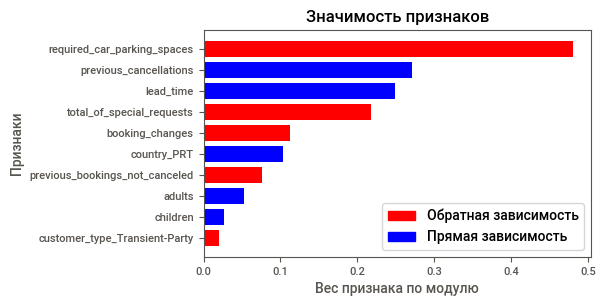

In [62]:
plt.figure(figsize=(5, 3))

# определяем цвет столбца в зависимости от типа характера связи
colors = ['red' if feature in features_invers else 'blue' for feature in feature_weights_abs.index]

plt.barh(feature_weights_abs.index, feature_weights_abs, color=colors)

plt.xlabel('Вес признака по модулю')
plt.ylabel('Признаки')
plt.title('Значимость признаков')

# задаем элементы легенды
legend_elements = [
    Patch(facecolor='red', edgecolor='red', label='Обратная зависимость'),
    Patch(facecolor='blue', edgecolor='blue', label='Прямая зависимость')
]

plt.legend(handles=legend_elements, loc='best')


plt.show()

**Вывод:**

Клиент, склонный к отказу от брони:

* не бронирует место для автомобиля,

* часто отменял предыдущие бронирования,

* имеет большое количество дней между датой бронирования и датой прибытия,

* имеет мало специальных запросов,

* не вносит изменений в параметры заказа,

* имеет португальское гражданство.

### Общий вывод.

В рамках данного проекта было проведено исследование истории поведения клиентов и отмены бронирований сети отелей «Как в гостях» с целью разработки системы прогнозирования отказов от брони.

Данные, предоставленные для анализа, состоят из двух наборов: обучающей и тестовой выборки. Пропусков и явных дубликатов не обнаружено. Выбросы, неявные дубликаты и аномалии были удалены. 

Для целей машинного обучения были отобраны и классифицированы признаки клиентов. Числовые небинарные данные стандартизированы, а категориальные признаки были закодированы с использованием техники One-Hot Encoding (OHE).


Для достижения поставленной цели было проведено исследование четырех моделей, предназначенных для бинарной классификации:

*	Логистическая регрессия

*	Метод K-ближайших соседей

*	Случайный лес

*	CatBoost

В качестве основной метрики для оценки эффективности моделей была выбрана метрика recall, которая отражает способность модели минимизировать количество ложноотрицательных прогнозов.


Из всех рассмотренных моделей наилучшей для решения поставленной задачи оказалась модель "Логистическая регрессия". Ее проверка на тестовой выборке показала, что модель корректно предсказывает отмену бронирования в 77% случаев, и из 5 клиентов, классифицированных как «ненадежные», 2 действительно отменили бронирование.

Оценка бизнес-метрики за тестовый период, показала, что при использовании системы прогнозирования прибыль отеля увеличится на 19,3% (6,9 млн рублей), что в 17 раз превышает сумму затрат на внедрение.

Также в ходе исследования были выявлены характеристики ненадежных клиентов, такие как отсутствие бронирования места для автомобиля, частые отмены предыдущих бронирований, большое количество дней между датой бронирования и датой прибытия, низкое количество специальных запросов, редкие изменения параметров заказа и португальское гражданство. 

Выбранная модель может служить полезным инструментом для сети отелей «Как в гостях» для улучшения финансовых результатов.